## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import xgboost as xgb

## Load & Initial Clean 

In [2]:
df = pd.read_csv('/Users/adityadeshpande/Desktop/others/Big Data Project/data 2.csv', encoding='ISO-8859-1')

# Drop missing rows for critical fields
df_clean = df.dropna(subset=['CustomerID', 'Description']).copy()

# Ensure InvoiceDate is datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

# Remove negative and zero values for Quantity and UnitPrice
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)].copy()

# Create TotalRevenue safely with .loc
df_clean.loc[:, 'TotalRevenue'] = df_clean['Quantity'] * df_clean['UnitPrice']


## Aggregation (Customer Level)

In [3]:
customer_agg = df_clean.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'TotalRevenue': 'sum'
}).reset_index()

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_agg[['Quantity', 'UnitPrice', 'TotalRevenue']])
scaled_df = pd.DataFrame(scaled_features, columns=['Quantity_scaled', 'UnitPrice_scaled', 'TotalRevenue_scaled'])
scaled_df['CustomerID'] = customer_agg['CustomerID'].values


## Descriptive Analytics

In [4]:
# 1) Total Revenue over time
revenue_over_time = df_clean.groupby(df_clean['InvoiceDate'].dt.date)['TotalRevenue'].sum()

# 2) Top 10 Products by Total Revenue
top_products = df_clean.groupby('Description')['TotalRevenue'].sum().sort_values(ascending=False).head(10)

# 3) Top Returned Products (use original df to capture negatives)
returned_products = df[df['Quantity'] < 0].groupby('Description')['Quantity'].sum().sort_values().head(10)

## Plots

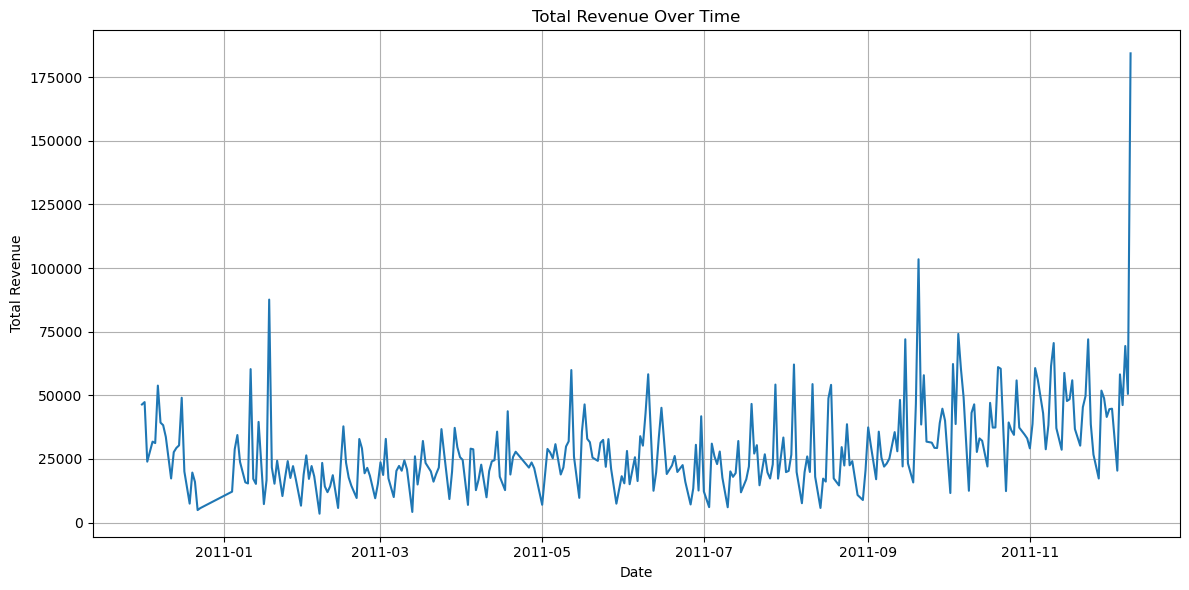

In [5]:
plt.figure(figsize=(12, 6))
revenue_over_time.plot()
plt.title('Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

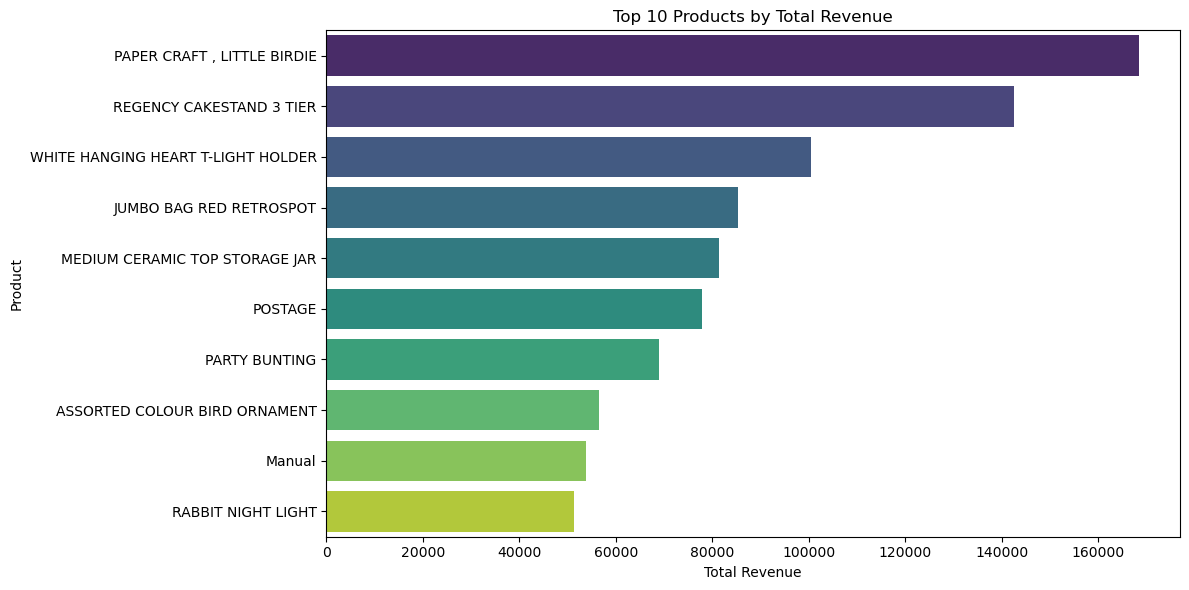

In [6]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title('Top 10 Products by Total Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

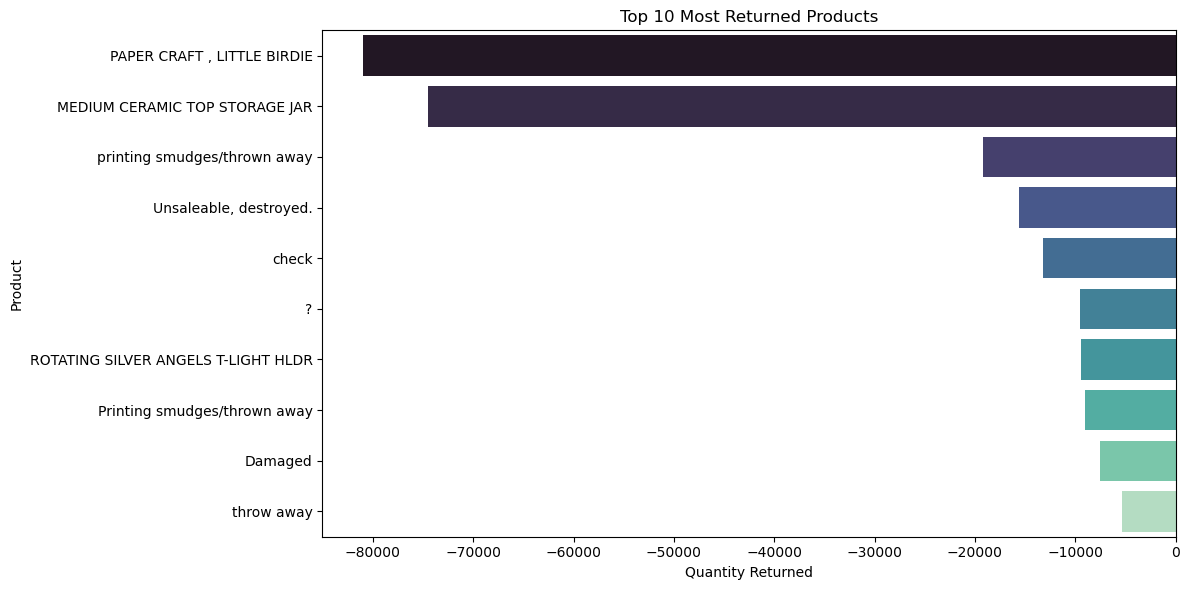

In [7]:
plt.figure(figsize=(12, 6))
sns.barplot(x=returned_products.values, y=returned_products.index, palette="mako")
plt.title('Top 10 Most Returned Products')
plt.xlabel('Quantity Returned')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

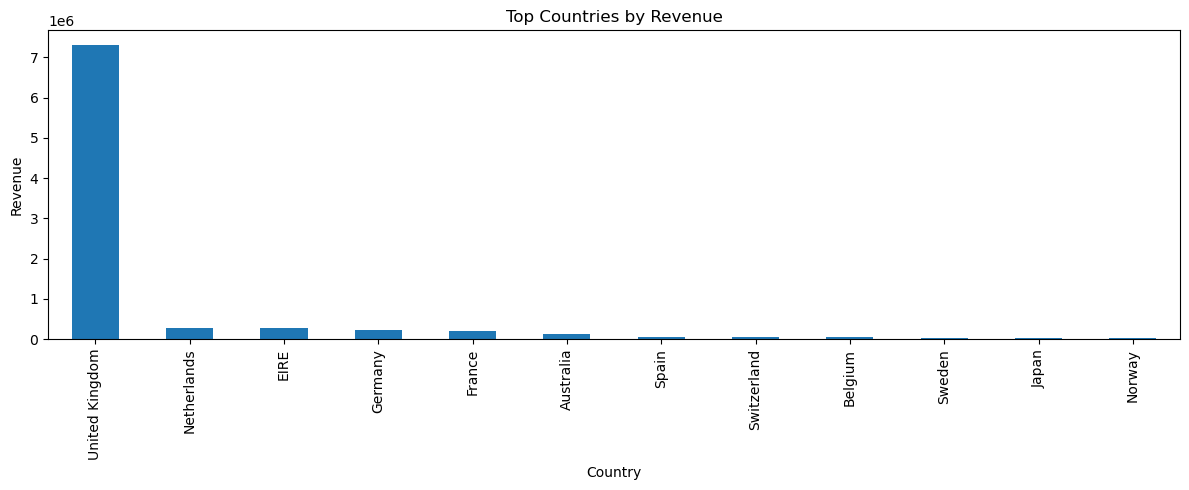

In [8]:
#Country revenue share (backs geo prescription)
country_rev = (df_clean.groupby('Country')['TotalRevenue']
               .sum().sort_values(ascending=False).head(12))
plt.figure(figsize=(12, 5))
country_rev.plot(kind='bar')
plt.title('Top Countries by Revenue')
plt.ylabel('Revenue')
plt.xlabel('Country')
plt.tight_layout()
plt.show()

## Baseline Models (TotalRevenue ~ Quantity + UnitPrice)

In [9]:
X = customer_agg[['Quantity', 'UnitPrice']]
y = customer_agg['TotalRevenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2 Score": r2_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
print(results_df)

               Model         RMSE  R2 Score
0  Linear Regression  5766.850648  0.675365
1      Decision Tree  5252.532911  0.730688
2      Random Forest  5191.826644  0.736877


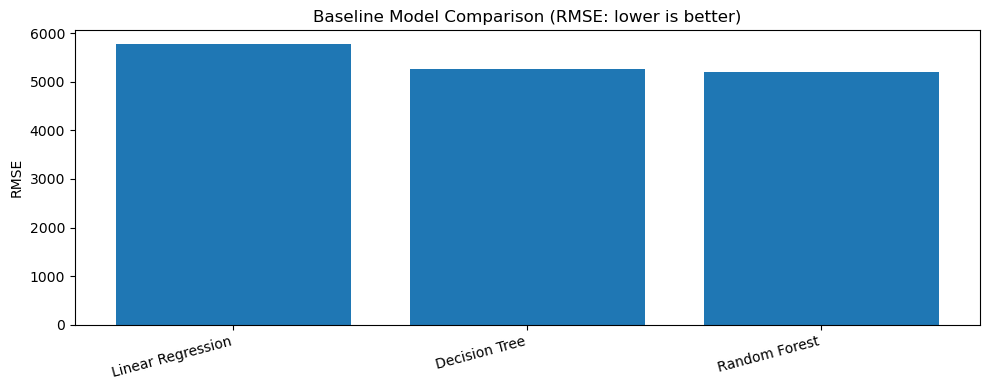

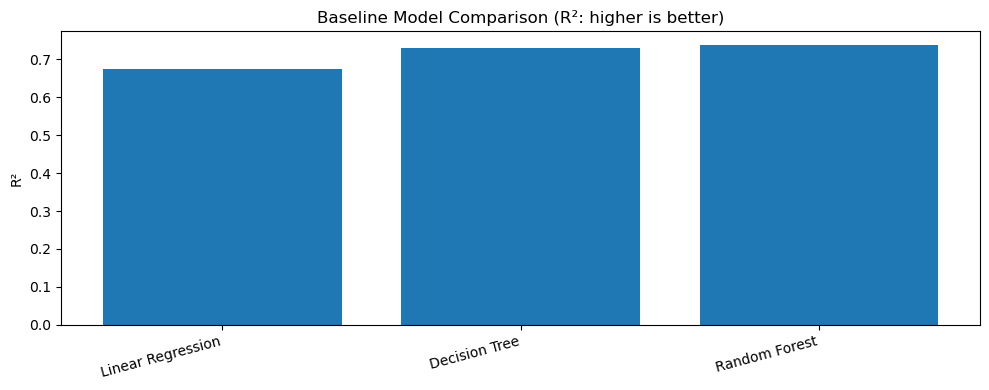

In [10]:
# Baseline performance visuals (RMSE, R²)
plt.figure(figsize=(10,4))
plt.bar(results_df['Model'], results_df['RMSE'])
plt.title('Baseline Model Comparison (RMSE: lower is better)')
plt.ylabel('RMSE')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(results_df['Model'], results_df['R2 Score'])
plt.title('Baseline Model Comparison (R²: higher is better)')
plt.ylabel('R²')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## First Round of Refinements on same target/features

In [11]:
# Polynomial Linear Regression (degree 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly2 = poly_model.predict(X_test)
poly2_results = {
    "Model": "Polynomial Regression (deg=2)",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_poly2)),
    "R2 Score": r2_score(y_test, y_pred_poly2)
}

# Tuned Decision Tree (GridSearchCV)
dt_params = {'max_depth': [3, 5, 10, 15], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5,
                       scoring='neg_mean_squared_error')
dt_grid.fit(X_train, y_train)
y_pred_dt_grid = dt_grid.predict(X_test)
dt_grid_results = {
    "Model": "Tuned Decision Tree",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_dt_grid)),
    "R2 Score": r2_score(y_test, y_pred_dt_grid)
}

In [12]:
# Tuned Random Forest (GridSearchCV)
rf_params_grid = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params_grid, cv=5,
                       scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
y_pred_rf_grid = rf_grid.predict(X_test)
rf_grid_results = {
    "Model": "Tuned Random Forest",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf_grid)),
    "R2 Score": r2_score(y_test, y_pred_rf_grid)
}

refined_models_df_round1 = pd.DataFrame([
    poly2_results,
    dt_grid_results,
    rf_grid_results
])
print(refined_models_df_round1)

                           Model         RMSE  R2 Score
0  Polynomial Regression (deg=2)  5670.044721  0.686172
1            Tuned Decision Tree  6077.282170  0.639473
2            Tuned Random Forest  5156.044292  0.740491


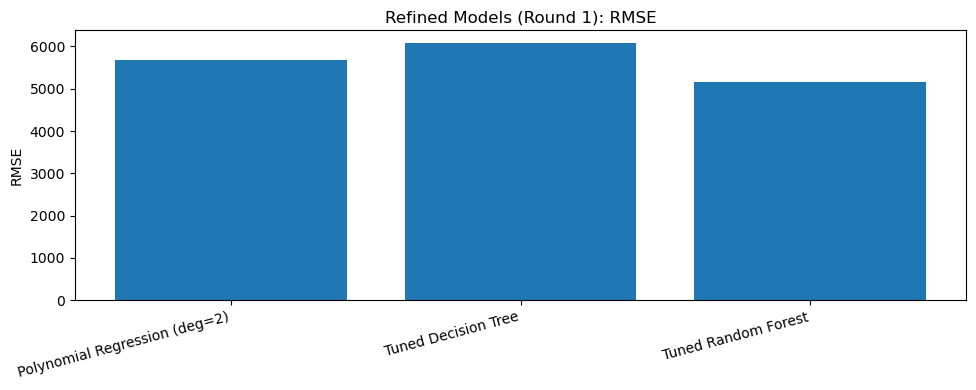

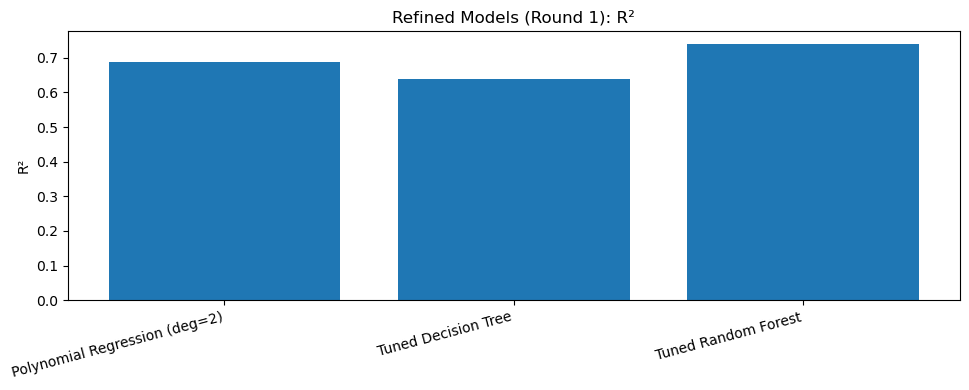

In [13]:
# Round-1 performance visuals
plt.figure(figsize=(10,4))
plt.bar(refined_models_df_round1['Model'], refined_models_df_round1['RMSE'])
plt.title('Refined Models (Round 1): RMSE')
plt.ylabel('RMSE')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(refined_models_df_round1['Model'], refined_models_df_round1['R2 Score'])
plt.title('Refined Models (Round 1): R²')
plt.ylabel('R²')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## Advanced Feature Engineering + Advanced Models

In [14]:
# Feature engineering on the same aggregated frame
customer_agg_fe = customer_agg.copy()
customer_agg_fe['AvgRevenuePerItem']   = customer_agg_fe['TotalRevenue'] / customer_agg_fe['Quantity']
customer_agg_fe['LogQuantity']         = np.log1p(customer_agg_fe['Quantity'])
customer_agg_fe['LogRevenue']          = np.log1p(customer_agg_fe['TotalRevenue'])
customer_agg_fe['RevenuePerUnitPrice'] = customer_agg_fe['TotalRevenue'] / customer_agg_fe['UnitPrice']

X_fe = customer_agg_fe[['LogQuantity', 'UnitPrice', 'AvgRevenuePerItem', 'RevenuePerUnitPrice']]
y_fe = customer_agg_fe['LogRevenue']

X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

In [15]:
# Polynomial Regression (degree=3, interaction only)
poly3_model = Pipeline([
    ('poly', PolynomialFeatures(degree=3, interaction_only=True)),
    ('lr', LinearRegression())
])
poly3_model.fit(X_train_fe, y_train_fe)
y_pred_poly3 = poly3_model.predict(X_test_fe)
poly3_results = {
    "Model": "Polynomial Regression (deg=3)",
    "RMSE": np.sqrt(mean_squared_error(y_test_fe, y_pred_poly3)),
    "R2 Score": r2_score(y_test_fe, y_pred_poly3)
}

In [16]:
# Tuned Decision Tree (RandomizedSearchCV)
dt_param_dist = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
dt_random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    dt_param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)
dt_random_search.fit(X_train_fe, y_train_fe)
y_pred_dt_fe = dt_random_search.predict(X_test_fe)
dt_fe_results = {
    "Model": "Tuned Decision Tree",
    "RMSE": np.sqrt(mean_squared_error(y_test_fe, y_pred_dt_fe)),
    "R2 Score": r2_score(y_test_fe, y_pred_dt_fe)
}

In [17]:
# Tuned Random Forest (GridSearchCV)
rf_params_fe = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_params_fe, cv=5,
                         scoring='neg_mean_squared_error', n_jobs=-1)
rf_search.fit(X_train_fe, y_train_fe)
y_pred_rf_fe = rf_search.predict(X_test_fe)
rf_fe_results = {
    "Model": "Tuned Random Forest",
    "RMSE": np.sqrt(mean_squared_error(y_test_fe, y_pred_rf_fe)),
    "R2 Score": r2_score(y_test_fe, y_pred_rf_fe)
}

In [18]:
# Tuned XGBoost (GridSearchCV)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_search = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_search.fit(X_train_fe, y_train_fe)
y_pred_xgb = xgb_search.predict(X_test_fe)
xgb_results = {
    "Model": "Tuned XGBoost",
    "RMSE": np.sqrt(mean_squared_error(y_test_fe, y_pred_xgb)),
    "R2 Score": r2_score(y_test_fe, y_pred_xgb)
}

In [19]:
# Final comparison for advanced feature set
refined_models_df = pd.DataFrame([
    poly3_results,
    dt_fe_results,
    rf_fe_results,
    xgb_results
])
print(refined_models_df)

                           Model      RMSE  R2 Score
0  Polynomial Regression (deg=3)  0.206979  0.973278
1            Tuned Decision Tree  0.133130  0.988945
2            Tuned Random Forest  0.091306  0.994800
3                  Tuned XGBoost  0.083330  0.995669


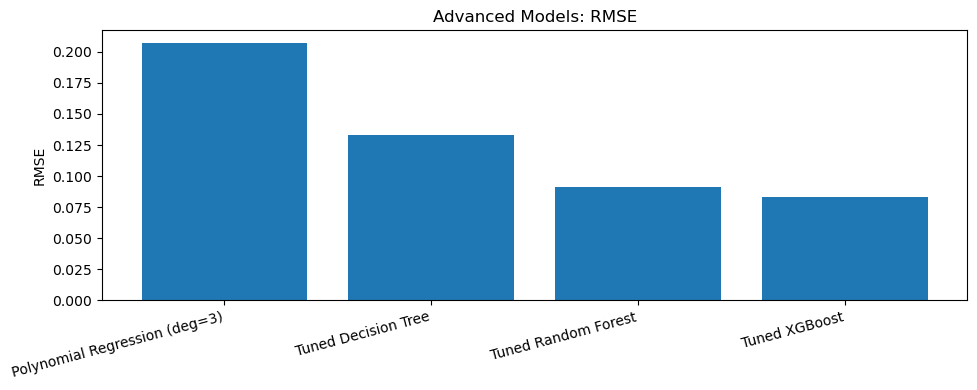

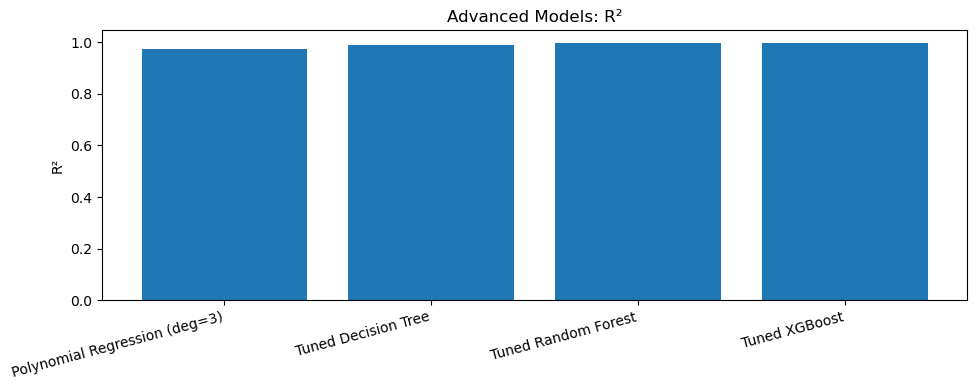

In [20]:
# Advanced performance visuals 
plt.figure(figsize=(10,4))
plt.bar(refined_models_df['Model'], refined_models_df['RMSE'])
plt.title('Advanced Models: RMSE')
plt.ylabel('RMSE')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(refined_models_df['Model'], refined_models_df['R2 Score'])
plt.title('Advanced Models: R²')
plt.ylabel('R²')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

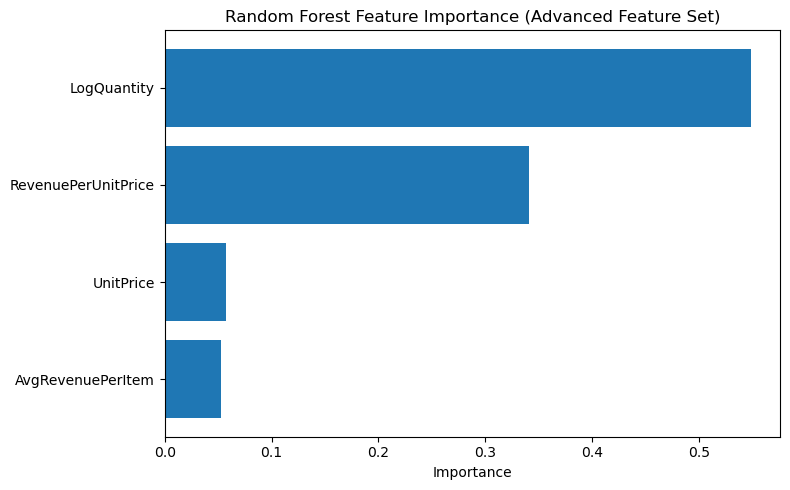

In [21]:
# Feature importance from best Random Forest (advanced) 
best_rf = rf_search.best_estimator_
importances = best_rf.feature_importances_
feat_names = X_train_fe.columns

fi = (pd.DataFrame({'feature': feat_names, 'importance': importances})
        .sort_values('importance', ascending=False))

plt.figure(figsize=(8,5))
plt.barh(fi['feature'], fi['importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance (Advanced Feature Set)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

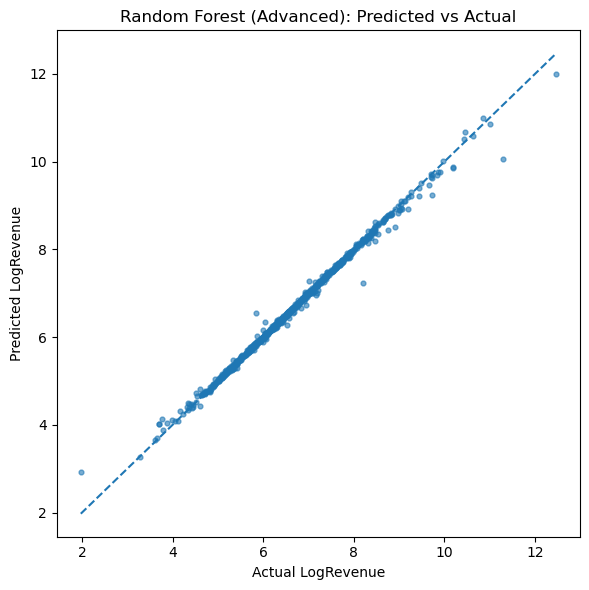

In [22]:
# Diagnostics for the selected RF model

# Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test_fe, y_pred_rf_fe, s=12, alpha=0.6)
lims = [min(y_test_fe.min(), y_pred_rf_fe.min()), max(y_test_fe.max(), y_pred_rf_fe.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual LogRevenue')
plt.ylabel('Predicted LogRevenue')
plt.title('Random Forest (Advanced): Predicted vs Actual')
plt.tight_layout()
plt.show()

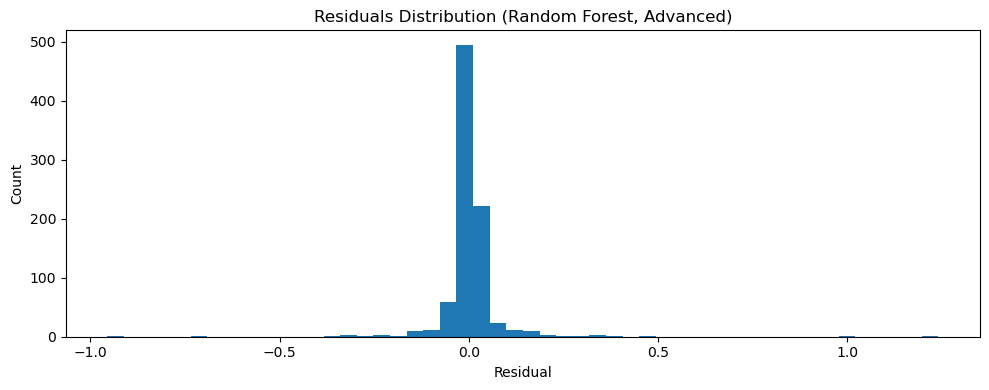

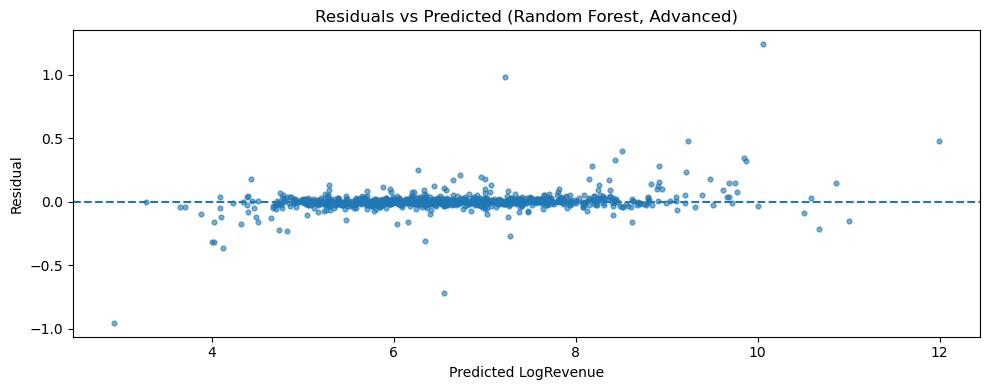

In [23]:
# Residuals
resid = y_test_fe - y_pred_rf_fe
plt.figure(figsize=(10,4))
plt.hist(resid, bins=50)
plt.title('Residuals Distribution (Random Forest, Advanced)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.scatter(y_pred_rf_fe, resid, s=12, alpha=0.6)
plt.axhline(0, ls='--')
plt.title('Residuals vs Predicted (Random Forest, Advanced)')
plt.xlabel('Predicted LogRevenue')
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

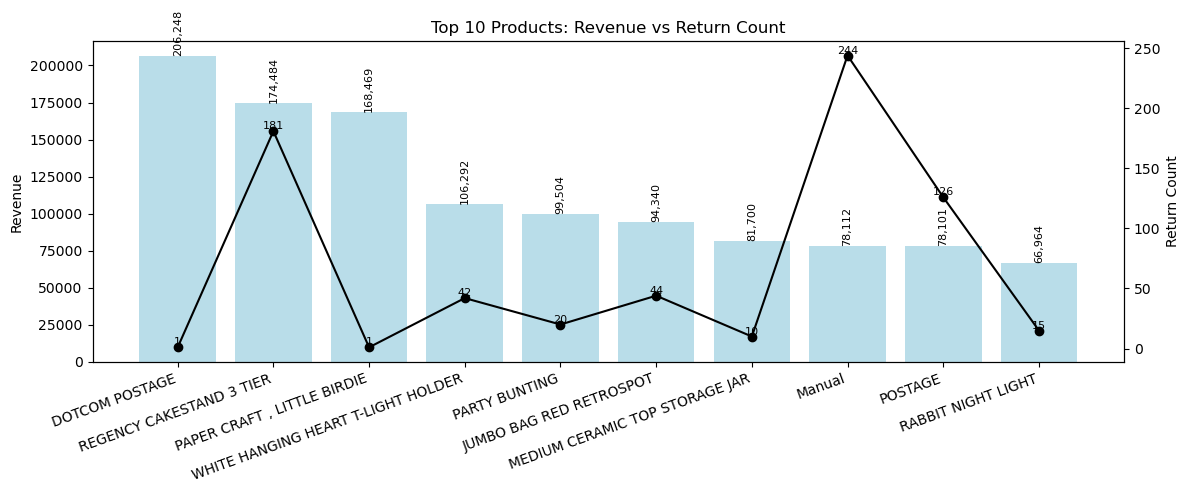

In [24]:
# Top products revenue vs return count overlay
# Uses raw df to pick up negative quantities (returns)

prod_rev = (df[df['Quantity']>0]
            .assign(TotalRevenue=lambda x: x['Quantity']*x['UnitPrice'])
            .groupby('Description')['TotalRevenue'].sum())
prod_rets = (df[df['Quantity']<0]
             .groupby('Description')['Quantity'].count())

top_desc = prod_rev.sort_values(ascending=False).head(10).index
plot_df = pd.DataFrame({
    'Description': top_desc,
    'Revenue': prod_rev.loc[top_desc].values,
    'ReturnCount': prod_rets.reindex(top_desc).fillna(0).values
})

fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()

# For revenue
bars = ax1.bar(plot_df['Description'], plot_df['Revenue'], alpha=0.85, color='lightblue')

# For return count
points = ax2.plot(plot_df['Description'], plot_df['ReturnCount'], marker='o', color='black')

ax1.set_title('Top 10 Products: Revenue vs Return Count')
ax1.set_ylabel('Revenue')
ax2.set_ylabel('Return Count')

# Rotate labels safely
plt.setp(ax1.get_xticklabels(), rotation=20, ha='right')

# Annotate
for bar, value in zip(bars, plot_df['Revenue']):
    ax1.text(
        bar.get_x() + bar.get_width()/2,  # X center
        bar.get_height(),                 # Y = top of bar
        f'{int(value):,}',                # formatted number
        ha='center', va='bottom', fontsize=8, rotation=90
    )

for x, y in zip(plot_df['Description'], plot_df['ReturnCount']):
    ax2.text(
        x, y, str(int(y)),
        color='black', fontsize=8, ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()
